#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf

%matplotlib inline

In [45]:
from IPython.display import display, clear_output

##  Loading data

In [4]:
training_data_full = pd.read_csv('training.csv')
#training_data.info()

# I will do the splitting here, so that I have a test set that has never been passed 
# through the network.

In [5]:
# Splitting into training and cross-validation sets. 
training_data, training_cv = train_test_split(training_data_full, test_size = 50, random_state = 42) #set the state.

In [6]:
training_data.shape, training_cv.shape

((6999, 31), (50, 31))

In [7]:
# Prepearing cv data and a smaller subset, to try and avoid crashin the kernel.  
keypoints_cv = training_cv.drop('Image', axis = 1)


x_cv = training_cv['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
x_cv = np.vstack(x_cv.iloc[i] for i in range(len(x_cv)))

In [8]:
# Computing mean keypoint position from training set. 

keypoints_mean = training_data.drop('Image', axis = 1).mean()

In [9]:
def next_batch(batch_size):
    
    #samples = training_data.sample(n = 100, random_state=42)
    
    samples = training_data.sample(n = batch_size)
    
    keypoints = samples.drop('Image', axis = 1)
    
    images = samples['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))
    images = np.vstack(images.iloc[i] for i in range(len(images)))
    
    #images_train, images_test, keypoints_train, keypoints_test = train_test_split(
    #    images, keypoints, test_size=0.3, random_state=42)
    
    #return images_train, images_test, keypoints_train, keypoints_test
    
    return images, keypoints

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [10]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 4, 4, 1],
                          strides=[1, 4, 4, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


In [11]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 9216])
keypoints_true = tf.placeholder(tf.float32, [None, 30])
lr = tf.placeholder(tf.float32)

In [12]:
x_images = tf.reshape(x, [-1,96,96,1])

In [13]:
# LAYERS

convo1 = convolutional_layer(x_images, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 
convo1_pool = max_pool_2by2(convo1)   #output of 24 x 24 x 32

In [14]:
convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.
convo2_pool = max_pool_2by2(convo2) # 6 x 6 x 64

convo2_flat = tf.reshape(convo2_pool,[-1,6*6*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo2_flat,1024))

In [ ]:
"""convo3 = convolutional_layer(convo2_pool, [4,4,64,128]) # 4x4 filter, 64 outputs. SAME padding.
convo3_pool = max_pool_2by2(convo3) # 12 x 12 x 128
convo3_flat = tf.reshape(convo3_pool,[-1,12*12*128])
full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))"""

In [21]:
# DROPOUT AND OUTPOUT LAYER
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

keypoints_pred = normal_full_layer(full_one_dropout,30)

In [22]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/envs/tensor/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [23]:
# INITIALIZER

init = tf.global_variables_initializer()

In [24]:
saver = tf.train.Saver()

In [25]:
counter = 4

In [26]:
# Computing error from the mean in order to have a reference. This is the mark I have to beat. 

mean_keypoints_mse = ((keypoints_cv-keypoints_mean)**2).sum(axis = 1).mean()
mean_keypoints_mse

210.69596922581684

In [48]:
train_losses = []
cv_losses = []

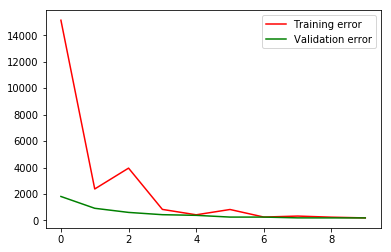

In [49]:
num_steps = 1000

with tf.Session() as sess:
        
    sess.run(init)
    #saver.restore(sess, "./saved_models/keypoints_cnn_3")
    #train_losses = []
    #cv_losses = []
    
    fig = plt.figure();
    ax = fig.add_subplot(1, 1, 1);
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = next_batch(5)
        
        _ , train_loss = sess.run([train, masked_loss], 
                                  feed_dict={x: x_batch, keypoints_true: keypoints_batch, 
                                             hold_prob: 0.5, lr:0.001})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        
        #if (iteration%20 == 0) and (iteration >0):
            #print(':')
        
        if iteration%100 == 0:
            
            cv_loss = sess.run(masked_loss,feed_dict={x:x_cv,keypoints_true:keypoints_cv,hold_prob:1.0})
            
            train_losses.append(train_loss)
            cv_losses.append(cv_loss)
            
            
            
            print('=======================================')
            print('Currently on step {}'.format(iteration))
            print('Train MSE: ', train_loss, '\n')
            print('CV MSE:', cv_loss, '\n')
            
            ax.cla()
            ax.plot(train_losses[1:], 'r', label = 'Training error')
            ax.plot(cv_losses[1:], 'g', label = 'Validation error')
            ax.legend()
            display(fig)
            
            print('=======================================')
            print('train_losses = ', train_losses, '\n')
            print('cv_losses = ', cv_losses)
            
            clear_output(wait = True)
            
        if iteration !=0 and iteration % 1000 == 0:
            #saver.save(sess, "./saved_models/keypoints_cnn_3"  )
            pass
    
    #saver.save(sess, "./saved_models/keypoints_cnn_" + str(counter) )
    #saver.save(sess, "./saved_models/keypoints_cnn_4"  )
    #counter +=1

In [ ]:
counter

In [32]:
with tf.Session() as sess:
    
    # Use your Saver instance to restore your saved rnn time series model
    saver.restore(sess, "./saved_models/keypoints_cnn_4")

    # Create a numpy array for your genreative seed from the last 12 months of the 
    # training set data. Hint: Just use tail(12) and then pass it to an np.array
        
    predictions = sess.run(keypoints_pred, feed_dict= {x:x_cv, hold_prob:1.0 })
    

INFO:tensorflow:Restoring parameters from ./saved_models/keypoints_cnn_4


In [33]:
predictions.shape

(50, 30)

In [35]:
x_cv.shape

(50, 9216)

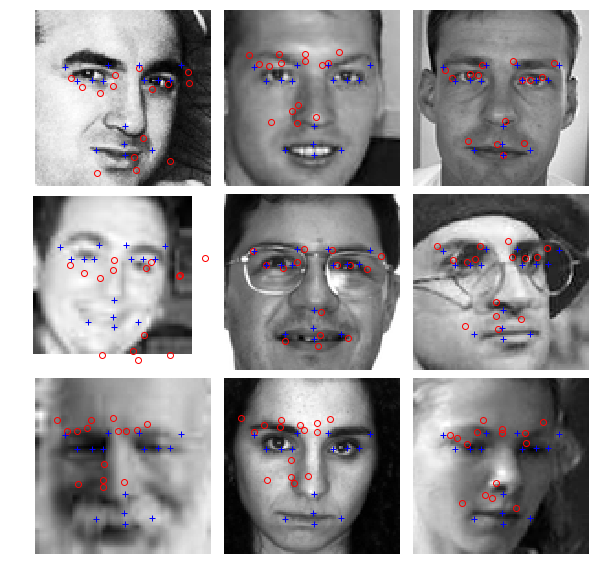

In [41]:
grid_size = 3
fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

selection = np.random.randint(len(x_cv), size = grid_size**2, )

mean_x_points = [keypoints_mean[j] for j in range(0,30,2)]
mean_y_points = [keypoints_mean[j+1] for j in range(0,30,2)]

for i, ax in zip(selection, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(x_cv[i].reshape((96,96)),cmap='gist_gray')

 # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [predictions[i][j] for j in range(0,30,2)]
    y_points = [predictions[i][j+1] for j in range(0,30,2)]
      
    #plotting keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    
  # Including mean keypoints
       
    ax.plot(mean_x_points, mean_y_points, 'b+', markerfacecolor = 'none')  